In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [17]:
plt.rcParams.update({'font.size': 20})

In [18]:
dataset_name = 'prepared_facebook_data'
folder_name = 'facebook_comm_vol'
DIR_WITH_FILES= '../other_data_experiments/{}/first experiment/'.format(folder_name)
GRAPHS_DIR = '../other_data_experiments/{}/graphs/'.format(folder_name)

In [19]:
grid_df = pd.read_csv(DIR_WITH_FILES+'res_grid_search_{}.csv'.format(dataset_name))
default_df = pd.read_csv(DIR_WITH_FILES+'res_default_{}.csv'.format(dataset_name))

group_df=pd.DataFrame([])
for i in range(1,11):
    df = pd.read_csv(DIR_WITH_FILES+\
                     'res_rand_groups_{}_{}.csv'.format(dataset_name, i))
    df['iter_num'] = range(1, df.shape[0]+1)    
    
    max_score_for_first_group_idx = df.loc[0:244, 'mean_test_score'].idxmax()
    params = eval(df.loc[max_score_for_first_group_idx, 'params'])
    max_depth = params['max_depth']
    min_child_weight = params['min_child_weight']

    df.loc[:, 'param_max_depth'].fillna(max_depth, inplace=True)
    df.loc[:, 'param_min_child_weight'].fillna(min_child_weight, inplace=True)
    
    max_score_for_first_group_idx = df.loc[244:243*2-1, 'mean_test_score'].idxmax()
    params = eval(df.loc[max_score_for_first_group_idx, 'params']) 

        
    param_alpha = params['alpha']
    param_lambda = params['lambda']    

    df.loc[:, 'param_lambda'].fillna(param_lambda, inplace=True)
    df.loc[:, 'param_alpha'].fillna(param_alpha, inplace=True)
    
    max_score_for_first_group_idx = df.loc[243*2+1:, 'mean_test_score'].idxmax()
    params = eval(df.loc[max_score_for_first_group_idx, 'params'])

    param_subsample = params['subsample']
    param_colsample_bytree = params['colsample_bytree']

    df.loc[:, 'param_subsample'].fillna(param_subsample, inplace=True)
    df.loc[:, 'param_colsample_bytree'].fillna(param_colsample_bytree, inplace=True)

    group_df = pd.concat([group_df, df], sort=False)
    
random_df=pd.DataFrame([])
for i in range(1,11):
    df = pd.read_csv(DIR_WITH_FILES+\
                     'res_rand_{}_{}.csv'.format(dataset_name, i))    
    df['iter_num'] = range(1, df.shape[0]+1)    
    
    random_df = pd.concat([random_df, df], sort=False)

In [20]:
df = pd.concat([default_df, grid_df, group_df, random_df], sort=False)

In [21]:
GRAPH_DIR='../other_data_experiments/{}/'.format(folder_name)

DEFAULT:  0.6362322637038218
GRID:  0.6647984628183977
CONFIDENCE INTERVALS:
 RS from 0.6664958672406426 to 0.6687238484775194
MEAN: 0.667609857859081, STD: 0.0017973202277167559
GRS from 0.6668586384702234 to 0.6684137069525024
MEAN: 0.6676361727113629, STD: 0.0012544791636587898


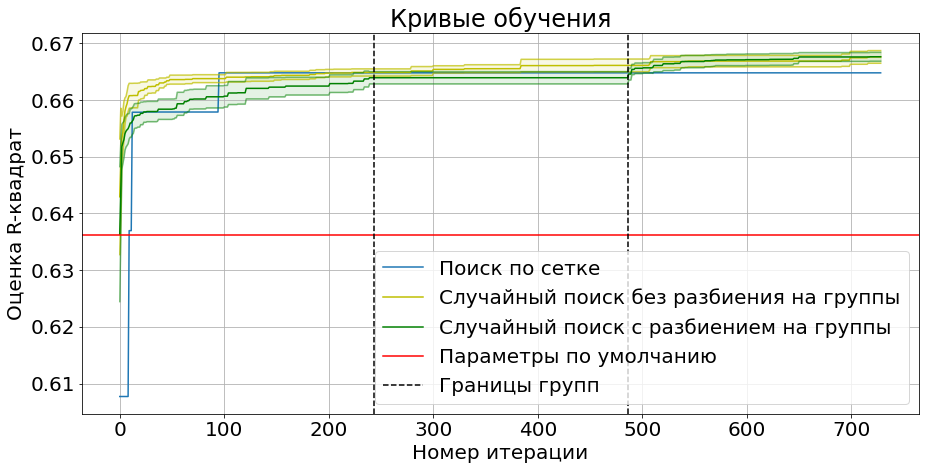

In [22]:
#comparison
# confidence intervals theory get from: 
# https://medium.com/ml-ai-study-group/confidence-interval-confidence-level-be58d250dd40


## GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params', 'mean_test_score'].cummax()


## RANDOM_SEARCH
#get best scores per itration for each random_search performance:
random_mean=pd.DataFrame([])
for i in random_df.run_number.unique():
    tmp=pd.DataFrame(random_df.loc[random_df.run_number==i, 
                                   "mean_test_score"].copy().cummax())
    tmp["iter_num"]=random_df.loc[random_df.run_number==i, "iter_num"]
    random_mean=pd.concat([random_mean, tmp], sort=False)
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=random_mean.shape[0]/random_mean.iter_num.max() 
random_std_real=random_mean.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std_real*z)/np.sqrt(n) #confidence interval value 
random_mean=random_mean.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):
group_mean=pd.DataFrame([])
for i in group_df.run_number.unique():
    tmp=pd.DataFrame(group_df.loc[group_df.run_number==i, "mean_test_score"].cummax())
    tmp["iter_num"]=group_df.loc[group_df.run_number==i, "iter_num"]
    group_mean=pd.concat([group_mean, tmp], sort=False)

n=group_mean.shape[0]/group_mean.iter_num.max() # now n=10
group_std_real=group_mean.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std_real*z)/np.sqrt(n) 
group_mean=group_mean.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=default_df['mean_test_score']
print("DEFAULT: ", default_perf.values[0])


## PLOT
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(0, grid_perf.shape[0]))

#grid plot:
plt.plot(x, grid_perf, label="Поиск по сетке")
print("GRID: ", grid_perf.iloc[-1])

#conf for random:
plt.plot(x, random_mean, color="y", label="Случайный поиск без разбиения на группы")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 
print("CONFIDENCE INTERVALS:\n RS from {} to {}".format(lower_random.iloc[-1], upper_random.iloc[-1]))
print("MEAN: {}, STD: {}".format(random_mean.iloc[-1], random_std_real.iloc[-1]))

#conf for group:
plt.plot(x, group_mean, color="green", label="Случайный поиск с разбиением на группы")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")
print("GRS from {} to {}".format(lower_group.iloc[-1], upper_group.iloc[-1]))
print("MEAN: {}, STD: {}".format(group_mean.iloc[-1], group_std_real.iloc[-1]))

#line for default values
plt.axhline(default_perf.values, label="Параметры по умолчанию", color='r')

plt.axvline(243, label="Границы групп", color='k', ls = "--")
plt.axvline(243*2, color='k', ls = "--")

plt.legend()
plt.title("Кривые обучения")
plt.ylabel("Оценка R-квадрат")
plt.xlabel("Номер итерации")
plt.savefig(GRAPHS_DIR+"scores20.jpg")
plt.show()

In [18]:
df.loc[df.experiment_name.astype(str).str.contains('default'),[
    'param_alpha', 'param_colsample_bytree', 'param_lambda',
       'param_min_child_weight', 'param_subsample']]=[0,1,1,1,1]

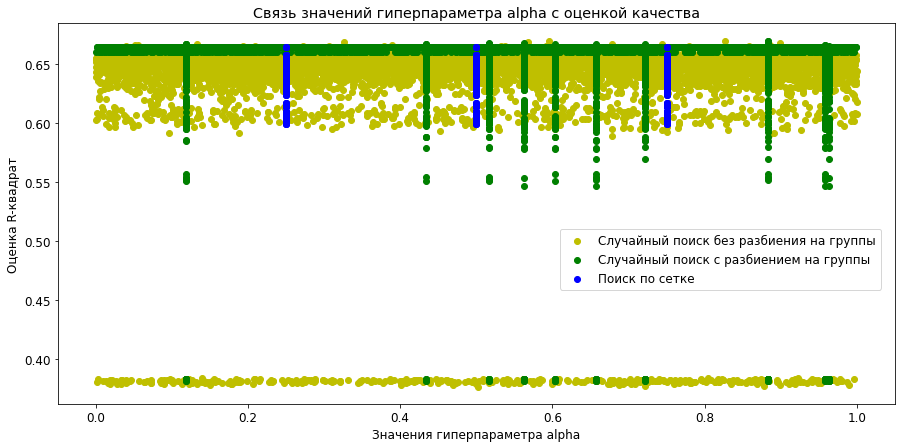

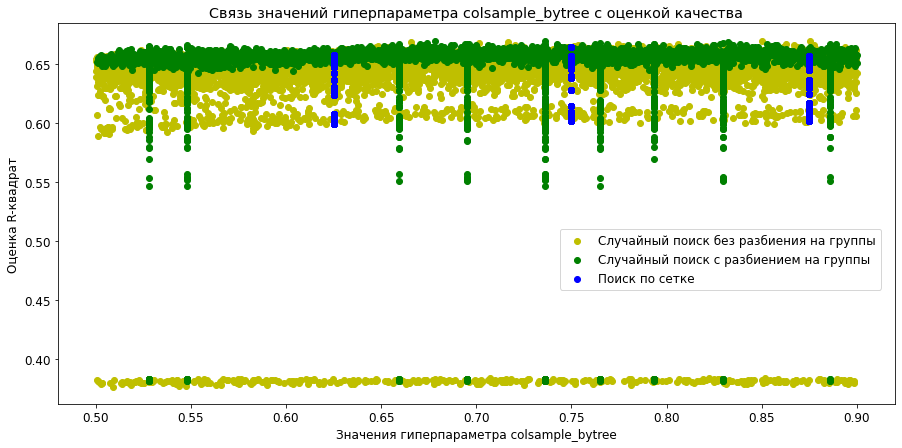

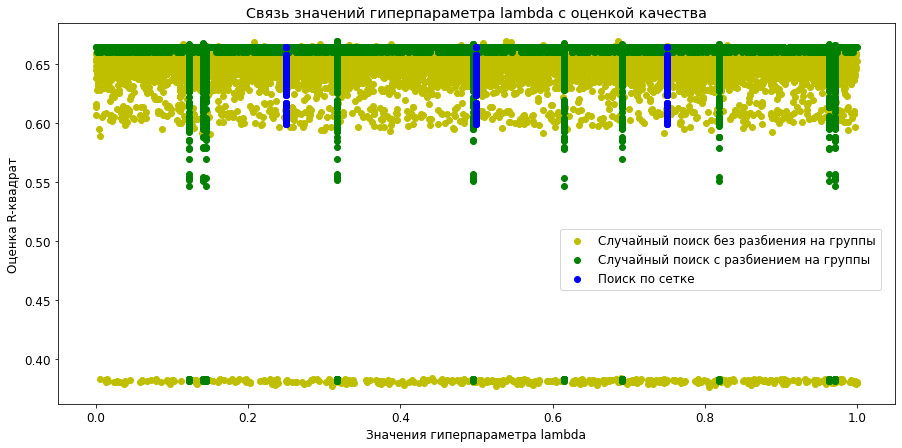

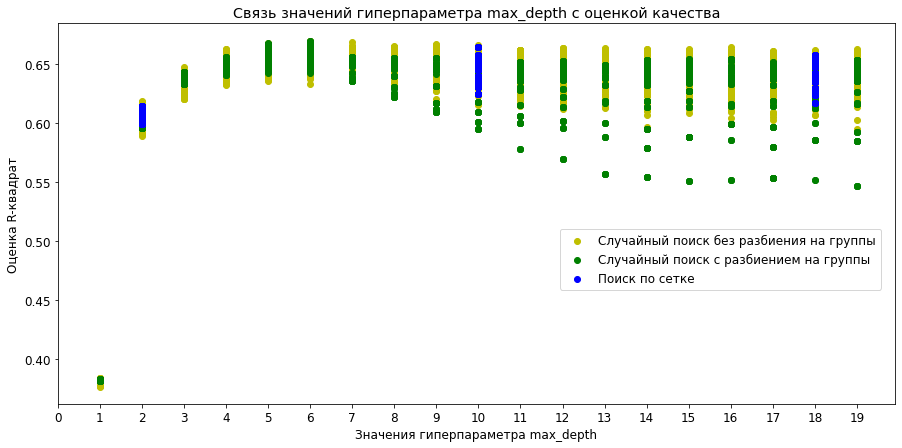

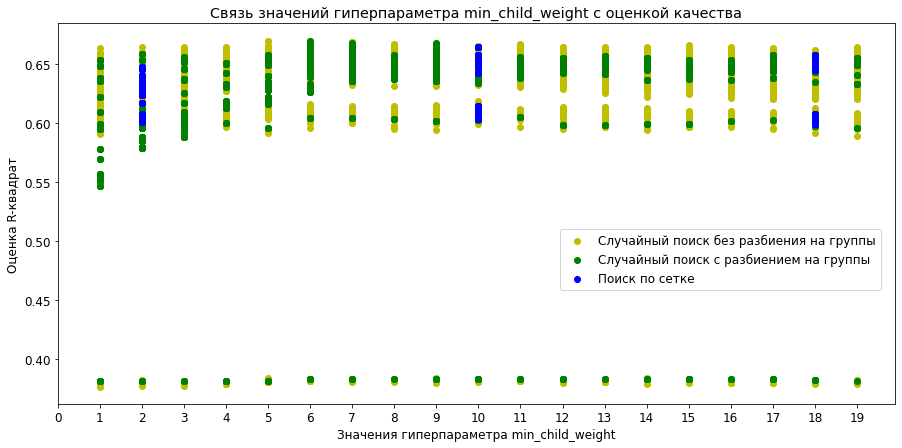

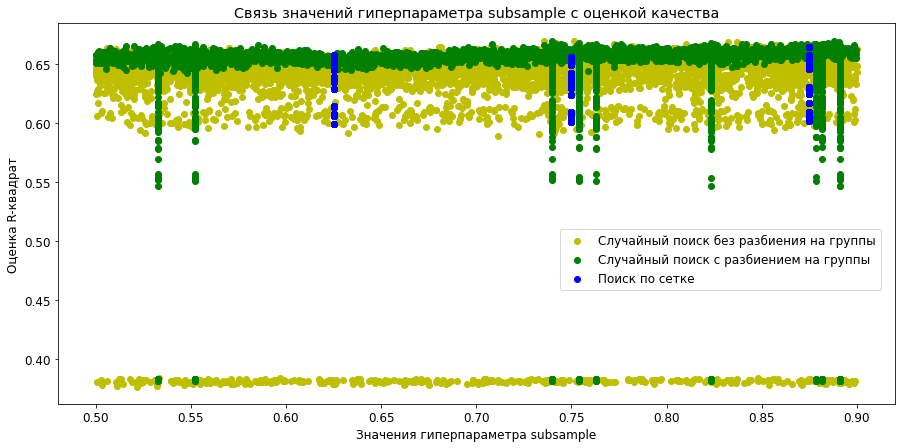

In [19]:
#params influence
params_list=['param_alpha', 'param_colsample_bytree',
             'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample']

df.loc[df.experiment_name.astype(str).str.contains("group"), 
       "experiment_name"] = "group_search"


exp_list = ("random_search", "group_search", "grid_search", "default")
exp_list = {"random_search": "Случайный поиск без разбиения на группы", 
               "group_search": "Случайный поиск с разбиением на группы", 
               "grid_search" : "Поиск по сетке"}
color_list = ("y","green", "b", "r")
for param in params_list:    
    plt.figure(figsize=(15,7))  
    right_bound = 0
    
    for exp_name, color in zip(exp_list, color_list):            
        data = df.loc[df.experiment_name == exp_name]
        x=data.loc[:,param]
        y=data.loc[:,'mean_test_score']
        if np.max(x) > right_bound:
            right_bound = np.max(x)
        plt.scatter(x, y, color = color, alpha=1, label = exp_list[exp_name])
        
    plt.title("Связь значений гиперпараметра {} с оценкой качества".format(param.split("_", 1)[1]))
    plt.xlabel("Значения гиперпараметра "+param.split("_", 1)[1])
    plt.ylabel("Оценка R-квадрат")
    plt.legend(loc=(0.6,0.3))
    if param in ("param_max_depth", "param_min_child_weight"):
        plt.xticks(range(0, int(right_bound)+1)) 
    plt.savefig(GRAPHS_DIR+"{} influence in {}.jpg".format(param, dataset_name))
    plt.show()

In [20]:
best_scores = df.groupby(by = ['experiment_name', 'run_number']
                        )['mean_test_score'].max()

In [21]:
best_iter = df.merge(best_scores, 
                     on =['experiment_name', 'run_number', 'mean_test_score']
                    ).groupby(['experiment_name','run_number'])['iter_num'].min()

In [22]:
best_info = pd.concat([best_iter, best_scores],join='inner', axis = 1)

In [23]:
best_info.reset_index()

,experiment_name,run_number,iter_num,mean_test_score
0,group_search,1.0,661.0,0.116481
1,group_search,2.0,653.0,0.116455
2,group_search,3.0,655.0,0.116671
3,group_search,4.0,719.0,0.116437
4,group_search,5.0,562.0,0.116711
5,group_search,6.0,705.0,0.116546
6,group_search,7.0,506.0,0.116276
7,group_search,8.0,707.0,0.115870
8,group_search,9.0,566.0,0.115202
9,group_search,10.0,506.0,0.116846


In [24]:
df.merge(best_info)[['experiment_name', 'run_number', 
                   'param_alpha', 'param_colsample_bytree',
                    'param_lambda','param_min_child_weight',
                    'param_subsample', 'param_max_depth']].groupby('experiment_name').std()

,run_number,param_alpha,param_colsample_bytree,param_lambda,param_min_child_weight,param_subsample,param_max_depth
experiment_name,,,,,,,
group_search,3.02765,0.260192,0.114567,0.335403,1.080123,0.133954,0.316228
random_search,3.02765,0.272084,0.070125,0.172780,2.394438,0.051090,1.429841


In [14]:
#для каждой группы в отдельности

In [15]:
group_df["group_num"]=2
group_df.loc[group_df.index<243, "group_num"]=1
group_df.loc[group_df.index>485, "group_num"]=3

In [16]:
best_group_scores = group_df.groupby(by = ['experiment_name', 'run_number', 'group_num']
                        )['mean_test_score'].max()

best_group_iter = group_df.merge(best_group_scores, 
                     on =['experiment_name', 'run_number', 'group_num', 'mean_test_score']
                    ).groupby(['experiment_name','run_number', 'group_num'])['iter_num'].min()
best_group_info = pd.concat([best_group_iter, best_group_scores],join='inner', axis = 1)

In [17]:
best_group_info.reset_index()

,experiment_name,run_number,group_num,iter_num,mean_test_score
0,random search for 1 group,1,1,57,0.114074
1,random search for 1 group,2,1,126,0.114074
2,random search for 1 group,3,1,160,0.112922
3,random search for 1 group,4,1,151,0.112827
4,random search for 1 group,5,1,11,0.114074
5,random search for 1 group,6,1,114,0.114074
6,random search for 1 group,7,1,77,0.112922
7,random search for 1 group,8,1,153,0.112499
8,random search for 1 group,9,1,91,0.112922
9,random search for 1 group,10,1,93,0.112922


In [20]:
best_group_info.groupby('experiment_name').std()

,iter_num,mean_test_score
experiment_name,,
random search for 1 group,46.305267,0.002523
random search for 2 group,0.000000,0.001740
random search for 3 group,57.432472,0.001254


In [20]:
# графики!!!


def autolabel(rects, add=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()+add
        ax.annotate('{}'.format(int(round(height-add,2))),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

In [21]:
best_iter = best_iter.reset_index()

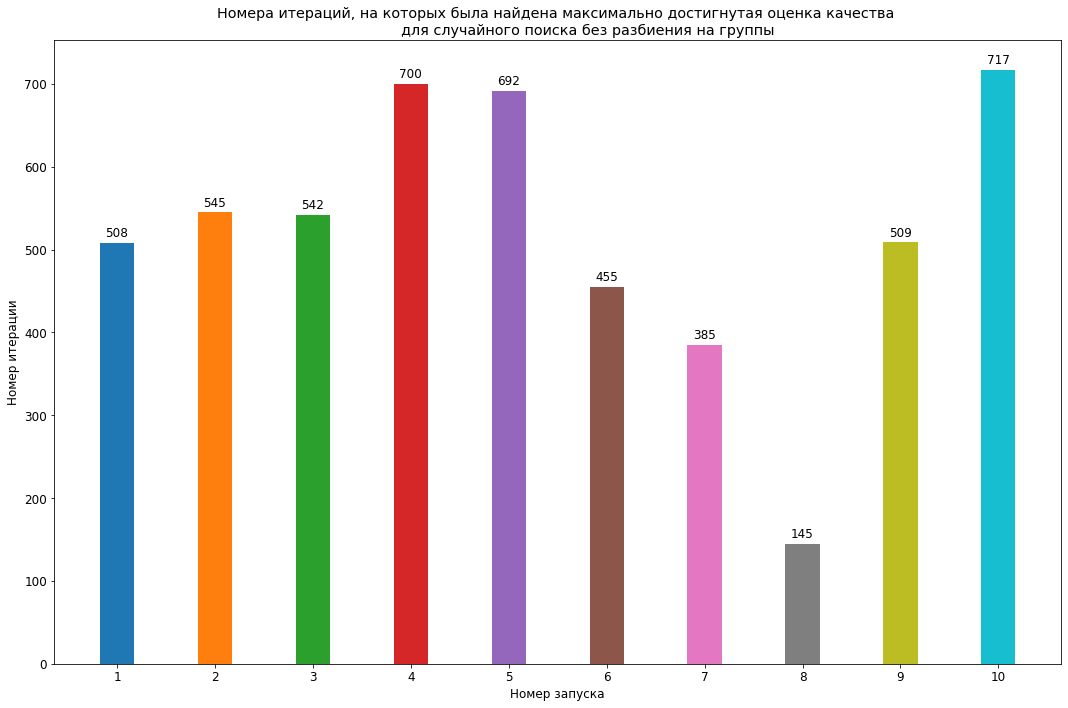

In [22]:
# on which min step algo get best result 
import math

best_iter=best_iter.loc[best_iter['experiment_name']=='random_search'].reset_index(drop=True)
x = np.arange(best_iter.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

labels_prefix=best_iter.loc[:,'experiment_name']
labels_postfix=best_iter.loc[:,'run_number']
labels=labels_postfix.values.astype(int).astype(str)

rects=[]
for row in range(best_iter.shape[0]):
    rects.append(ax.bar(row, best_iter.loc[row,'iter_num'], width, label=labels[row]))
    autolabel(rects[row])

ax.set_ylabel('Номер итерации')
ax.set_xlabel('Номер запуска')
ax.set_title("""Номера итераций, на которых была найдена максимально достигнутая оценка качества 
             для случайного поиска без разбиения на группы""")
ax.set_xticks(x)
ax.set_xticklabels(labels)

fig.tight_layout()

plt.savefig(GRAPHS_DIR+"best_step_RS.jpg")
plt.show()

In [23]:
best_group_iter=best_group_iter.reset_index()

In [32]:
best_group_iter.loc[best_group_iter.group_num == 2, "iter_num"] -= 243

In [25]:
best_group_iter.loc[best_group_iter.group_num == 3, "iter_num"] -= 243*2

In [26]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

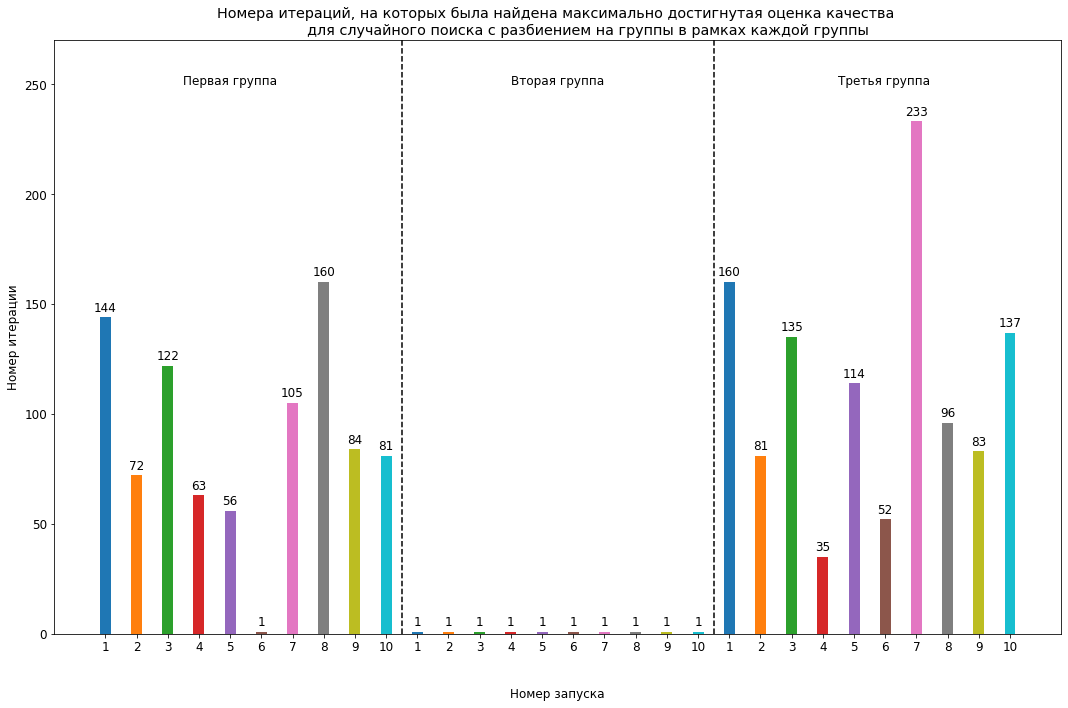

In [27]:
x = np.arange(best_group_iter.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))


labels_postfix=best_group_iter.loc[:,'run_number']
labels=labels_postfix.values.astype(int).astype(str)

rects=[]
for row in range(best_group_iter.shape[0]):
    rects.append(ax.bar(row, best_group_iter.loc[row,'iter_num'], width, label=labels[row]))
    autolabel(rects[row])

ax.set_ylabel('Номер итерации')
ax.set_ylim(0, 270)
ax.annotate("Первая группа",(2.5, 250))
ax.annotate("Вторая группа",(13, 250))
ax.annotate("Третья группа",(23.5, 250))
ax.set_xlabel("\n\nНомер запуска")
ax.set_title("""Номера итераций, на которых была найдена максимально достигнутая оценка качества 
             для случайного поиска с разбиением на группы в рамках каждой группы""")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.axvline(9.5, label="Границы групп", color='k', ls = "--")
plt.axvline(19.5, label="Границы групп", color='k', ls = "--")

fig.tight_layout()

plt.savefig(GRAPHS_DIR+"best_step_GRS.jpg")
plt.show()

In [28]:
df.merge(best_info.reset_index(), 
         how = 'inner', 
         on =['experiment_name', 'run_number', 'iter_num', 'mean_test_score']
        )[
    ['experiment_name', #'run_number', 'iter_num', 'mean_test_score',
     'param_max_depth', 'param_min_child_weight', 'params']
].drop_duplicates()

,experiment_name,param_max_depth,param_min_child_weight,params
0,group_search,5.0,19.0,"{'colsample_bytree': 0.5649373940586431, 'subs..."
1,group_search,5.0,19.0,"{'colsample_bytree': 0.5667548639796591, 'subs..."
2,group_search,5.0,19.0,"{'colsample_bytree': 0.5020153025847145, 'subs..."
3,group_search,5.0,17.0,"{'colsample_bytree': 0.6078203573515248, 'subs..."
4,group_search,5.0,19.0,"{'colsample_bytree': 0.5011845008540925, 'subs..."
5,group_search,5.0,19.0,"{'colsample_bytree': 0.579479240491051, 'subsa..."
6,group_search,5.0,19.0,"{'colsample_bytree': 0.5511583008104367, 'subs..."
7,group_search,4.0,18.0,"{'colsample_bytree': 0.501955696705688, 'subsa..."
8,group_search,5.0,12.0,"{'colsample_bytree': 0.5663438904202504, 'subs..."
9,group_search,5.0,19.0,"{'colsample_bytree': 0.5806991801287525, 'subs..."


In [32]:
best_scores.reset_index().groupby(
    'experiment_name')['mean_test_score'].agg(['mean', 'std'])

,mean,std
experiment_name,,
group_search,0.116350,0.000484
random_search,0.115956,0.000735


In [35]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'experiment_name', 'param_alpha',
       'param_colsample_bytree', 'param_lambda', 'param_min_child_weight',
       'param_subsample', 'run_number', 'iter_num'],
      dtype='object')